## Import data and create features for the machine learning algorithms

In [1]:
import pandas as pd

file_name = "Preprocessed_data.csv"
extra_col_name = "Group Stage"

data = pd.read_csv(file_name)
#data.head(5)
#data.describe(include="all")

In [2]:
df_feature = data
df_feature["Game Number"] = df_feature.groupby("Year").cumcount()+1

def featurize(row):
    home_goals = row["Home Team Goals"]
    away_goals = row["Away Team Goals"]
    
    # Simple result classes
    result = 1
    if home_goals > away_goals:
        result = 2
    elif home_goals < away_goals:
        result = 0
    row["Simple Result"] = result    
    
    # Multi result classes
    row["Win Home"] = row["Win Away"] = row["Draw"] = False   
    if home_goals > away_goals:
        row["Win Home"] = True
    elif home_goals < away_goals:
        row["Win Away"] = True
    else:
        row["Draw"] = True
 
    # Goal difference
    row["Goal Difference"] = abs(home_goals - away_goals)
    
    # Goals in match
    row["Total Goals"] = home_goals + away_goals
    return row

df_feature = df_feature.apply(featurize, axis=1)
df_feature.head(5)

,Year,Home Team Name,Home Team Goals,Away Team Name,Away Team Goals,Group Stage,Attack Home,Defense Home,Midfield Home,Nationality Home,...,Overall Away,rank Home,rank Away,Game Number,Simple Result,Win Home,Win Away,Draw,Goal Difference,Total Goals
0,2010.0,South Africa,1.0,Mexico,1.0,True,70.0,67.0,71.0,South Africa,...,77.0,83,17,1,1,False,False,True,0.0,2.0
1,2010.0,Uruguay,0.0,France,0.0,True,76.0,74.0,70.0,Uruguay,...,83.0,16,9,2,1,False,False,True,0.0,0.0
2,2010.0,Korea Republic,2.0,Greece,0.0,True,67.0,65.0,69.0,Korea Republic,...,76.0,47,13,3,2,True,False,False,2.0,2.0
3,2010.0,Argentina,1.0,Nigeria,0.0,True,83.0,78.0,81.0,Argentina,...,75.0,7,21,4,2,True,False,False,1.0,1.0
4,2010.0,England,1.0,USA,1.0,True,81.0,82.0,84.0,England,...,74.0,8,14,5,1,False,False,True,0.0,2.0


## Create different feature and scale combinations

In [3]:
#X_cols = ["Overall Home", "Attack Home", "Defense Home", "Midfield Home","rank Home", "Overall Away", "Attack Away", "Defense Away", "Midfield Away", "rank Away", "Game Number"]
#X_cols = ["Overall Home", "Attack Home", "Defense Home", "Midfield Home","Overall Away", "Attack Away", "Defense Away", "Midfield Away", "Game Number"]
#X_cols = ["rank Home", "rank Away"]
X_cols = ["Overall Home", "rank Home","Overall Away", "rank Away"]

import numpy as np

def scale_range(input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

#X_cols_home = ["Overall Home", "Attack Home", "Midfield Home", "Defense Home"]
#X_cols_away = ["Overall Away", "Attack Away", "Midfield Away", "Defense Away"]

data_feat = data
#data_feat["rank Home"] = data_feat["rank Home"].max() - data_feat["rank Home"].values
#data_feat["rank Away"] = data_feat["rank Away"].max() - data_feat["rank Away"].values

#data_feat["rank Home"] = scale_range(data_feat["rank Home"].astype(float).values, 50, 90)
#data_feat["rank Away"] = scale_range(data_feat["rank Away"].astype(float).values, 50, 90)

#data_feat[X_cols] = (data[X_cols] - 50.0) / (90.0 - 50)
#X_cols += [extra_col_name] if extra_col_name is not None else []

X = data_feat[X_cols]
#X = data["rank Home"].values - data["rank Away"].values
#X = X.reshape(-1, 1)
#X = data[X_cols_home].values.astype(float) - data[X_cols_away].values.astype(float)
#X = scale_range(X, -1, 1)
y = df_feature[["Goal Difference"]]

## Predict the goal difference with different ML algorithms

Random Forrest            MAE: 0.88 (+/- 0.62)  MAE(rounded prediction): 0.90
Gaussian Process          MAE: 0.72 (+/- 0.78)  MAE(rounded prediction): 0.73
XGBoost                   MAE: 0.96 (+/- 0.61)  MAE(rounded prediction): 0.96
Support Vector Machine    MAE: 0.79 (+/- 0.49)  MAE(rounded prediction): 0.79


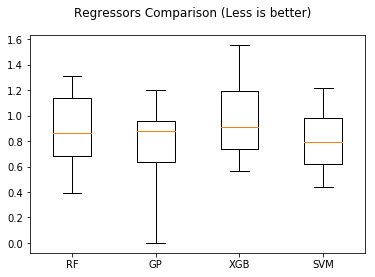

In [4]:
import collections

from sklearn.ensemble import RandomForestRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

Regressor = collections.namedtuple("Regressor", ["name", "tag", "regr"])
rfr = Regressor("Random Forrest", "RF", RandomForestRegressor(n_estimators=100))
gpr = Regressor("Gaussian Process", "GP", 
                GaussianProcessRegressor(RationalQuadratic() 
                                         #+ RationalQuadratic()
                                         #+ 0.1 * RBF()
                                         #+ 0.01 * ExpSineSquared()
                                         #+ 10 * WhiteKernel(noise_level=10),
                                         #alpha=0.2
                ))
xgbr = Regressor("XGBoost", "XGB", MultiOutputRegressor(XGBRegressor()))
svr = Regressor("Support Vector Machine", "SVM", MultiOutputRegressor(SVR()))

regressors = [rfr, gpr, xgbr, svr]

from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, confusion_matrix, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = []
tags = []
predictions = []
for regressor in regressors:
    scores = cross_val_score(regressor.regr, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    results.append([-score for score in scores])
    tags.append(regressor.tag)
    
    prediction = cross_val_predict(regressor.regr, X, y, cv=kfold)
    #prediction = [[round(x), round(y)] for x,y in prediction]
    #prediction = [round(float(x)) for x in prediction]
    predictions.append([prediction])
    
    score_predict = mean_absolute_error(y, prediction)
    
    print("{0:<25s} ".format(regressor.name) +"MAE: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2)
          + "  MAE(rounded prediction): %0.2f" % (score_predict))

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Regressors Comparison (Less is better)')
ax = fig.add_subplot(111)
plt.boxplot(results, showfliers=False, whis="range")
ax.set_xticklabels(tags)
plt.show()
#print(predictions)

## Predict the winner with different ML algorithms

In [5]:
y_one = df_feature[["Simple Result"]]

Random Forrest            Accuracy: 0.59 (+/- 0.53)
Gaussian Process          Accuracy: 0.64 (+/- 0.36)
Support Vector Machine    Accuracy: 0.53 (+/- 0.53)
XGBoost                   Accuracy: 0.57 (+/- 0.49)


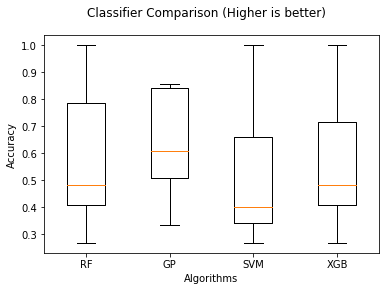

In [10]:
from sklearn import metrics
import numpy as np
from xgboost import XGBClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

xgbc = ("XGBoost", "XGB", XGBClassifier())
gpc = ("Gaussian Process", "GP", 
       GaussianProcessClassifier(RationalQuadratic() 
                                 #+ RationalQuadratic()
                                 #RBF()
                                 #+ 0.01 * ExpSineSquared()
                                 + 10 * WhiteKernel(noise_level=10),
                                 #multi_class="one_vs_rest"#alpha=0.2
                                )
      )
rfc = ("Random Forrest", "RF", RandomForestClassifier(n_estimators=100))
svc = ("Support Vector Machine", "SVM", SVC())

classifier = [rfc, gpc, svc, xgbc]

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

seed = 7
kfold = KFold(n_splits=10, random_state=seed)

results = []
tags = []
predictions = []
for name, tag, model in classifier:
    scores = cross_val_score(model, X, y_one, cv=kfold, scoring='accuracy')
    results.append(scores)
    tags.append(tag)
    
    prediction = cross_val_predict(model, X, y_one, cv=kfold, )#method="predict_proba")
    predictions.append(prediction)
    #score_roc = roc_auc_score(y_one, prediction[:,1])
    #print(score_roc)
    
    score_predict = metrics.accuracy_score(y_one, prediction)
    
    print("{0:<25s} ".format(name) +"Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
          #+ "  Accuracy: %0.2f" % (score_predict))
    

import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Classifier Comparison (Higher is better)')
ax = fig.add_subplot(111)
plt.boxplot(results, showfliers=False, whis="range")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
ax.set_xticklabels(tags)
plt.show()

## Analyze predictions made by the algorithms

In [7]:
#preds = [pred for kfold in predictions for pred in kfold]
#print(predictions.shape)
#list(zip(preds, y_one.values.tolist()))
predictions

[array([0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 0, 2, 2, 0,
        2, 1, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1,
        0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2,
        2, 0, 2, 2, 1, 2, 1, 0, 0, 2, 0, 2, 2, 0, 1, 2, 1, 2, 0, 1, 0, 2,
        0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2]),
 array([0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2,
        2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0,
        0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2,
        2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2,
        0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0,
        2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2]),
 array([0, 2, 2, 2, 

In [8]:
import numpy as np
u, count = np.unique(predictions[0], return_counts=True)
print(u)
print(count)

[0 1 2]
[52 13 79]
